In [10]:
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole

from itertools import combinations

import IPython
from IPython.display import display, Image
from PIL import Image

import numpy as np
import pandas as pd

import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df = pd.read_csv("SMILES_Big_Data_Set.csv")
df[5:10]

,SMILES,pIC50,mol,num_atoms,logP
5,O=C(Nc1cccc(-c2cnc3ccccc3n2)c1)C1CC1,4.60,<rdkit.Chem.rdchem.Mol object at 0x7f59a320ca50>,22,3.6453
6,O=C(Nc1cccc(-c2cnc3ccccc3n2)c1)c1ccco1,4.61,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c740>,24,4.1421
7,COc1cc(Nc2nccc(-c3ccc(Cl)cc3)n2)cc(OC)c1OC,4.67,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cc10>,26,4.5664
8,CN1C(=O)COc2c1cnc1ccc(Sc3nnc4c(F)cc(-c5cnn(C)c...,4.68,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cc80>,33,3.3235
9,COc1ccc2c(c1)C(=O)N(c1nc(C(=O)Nc3cnccc3N3CCNCC...,4.68,<rdkit.Chem.rdchem.Mol object at 0x7f59a320ccf0>,32,2.3690


{'Molecular Weight': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donor Count': 1, 'H-Bond Acceptor Count': 3}
1/1 [==============================] - 0s 44ms/step
Model Output: [[ 57.442303 -30.743273  52.238808]]
Reconstructed SMILES: CC(=O)Oc1ccccc1C(=O)O


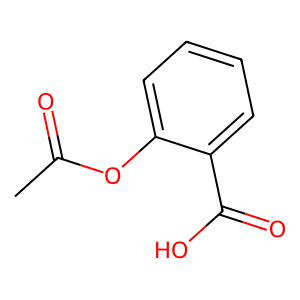

In [ ]:
import re
import random

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
    """

    def __init__(self, state_size, action_size, selected_X_train):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # discount rate
        self.gamma = 0.95
        # exploration rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # target model for stability
        self.target_model = self._build_model(selected_X_train) 
        self.update_target_model()

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store the experience in the replay memory

        Args:
            state (ndarray): Current state
            action (int): Action taken
            reward (float): Reward received
            next_state (ndarray): Next state
            done (bool): Whether the episode is done
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action given the current state

        Args:
            state (ndarray): Current state

        Returns:
            action (int): Chosen action
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        if state is None:
            state = np.zeros((1, self.state_size))
        else:
            state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Train the model by replaying experiences from the replay memory

        Args:
            batch_size (int): Size of the minibatch
        """
        # Sample a minibatch of experiences from the replay memory
        minibatch = random.sample(self.memory, batch_size)
        # print(minibatch)
        for state, action, reward, next_state, done in minibatch:
            if state is not None:
                if not done:
                    # Calculate the target value using the target model
                    target = (reward + self.gamma * np.amax(self.target_model.predict(next_state)[0]))
                else:
                    target = reward
                # Make the agent approximately map the current state to future discounted reward
                target_f = self.model.predict(state)
                target_f[0][action] = target
                # Train the model using the current state and target value
                self.model.fit(state, target_f, epochs=1, verbose=0)
        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """Load the model weights from a file"""
        self.model.load_weights(name)

    def save(self, name):
        """Save the model weights to a file"""
        self.model.save_weights(name)


def preprocess_smiles(smiles):
    """
    Preprocess the SMILES string by removing salts and stereochemistry information

    Args:
        smiles (str): SMILES string

    Returns:
        preprocessed_smiles (str): Preprocessed SMILES string
    """
    # Remove salts
    preprocessed_smiles = re.sub(r'\[.*?\]', '', smiles)
    # Remove stereochemistry information
    preprocessed_smiles = re.sub(r'[@]\S*', '', preprocessed_smiles)
    return preprocessed_smiles


def calculate_molecular_properties(smiles):
    """
    Calculate molecular properties of a compound given its SMILES string

    Args:
        smiles (str): SMILES string

    Returns:
        properties (dict): Dictionary of molecular properties
    """
    molecule = Chem.MolFromSmiles(smiles)
    properties = {}

    if molecule is not None:
        properties['Molecular Weight'] = Descriptors.MolWt(molecule)
        properties['LogP'] = Descriptors.MolLogP(molecule)
        properties['H-Bond Donor Count'] = Descriptors.NumHDonors(molecule)
        properties['H-Bond Acceptor Count'] = Descriptors.NumHAcceptors(molecule)

    return properties

def get_closest_smiles(predicted_features, X_train, smiles_list):
    """
    Find the closest SMILES string based on predicted molecular features and training data features.

    Args:
        predicted_features (ndarray): The features predicted by the model.
        X_train (ndarray): The training feature matrix (properties of the molecules in training set).
        smiles_list (list): List of SMILES strings corresponding to X_train.

    Returns:
        str: Closest SMILES string based on similarity to predicted features.
    """
    # Ensure X_train has the same number of features as predicted_features
    if X_train.shape[1] != predicted_features.shape[1]:
        # Here, you can slice X_train to match predicted_features' shape if needed
        X_train = X_train[:, :predicted_features.shape[1]]
        # print(X_train)

    # Calculate similarity (e.g., cosine similarity between the predicted features and training set features)
    similarities = cosine_similarity(predicted_features, X_train)
    similarities=similarities*100
    similarities=int(similarities[0][0])
    
    # Find the index of the most similar molecule
    # closest_index = np.argmax(similarities)
    closest_index = similarities
    print(closest_index)
    return smiles_list[closest_index]

if __name__ == '__main__':
    smiles = 'CC(=O)OC1=CC=CC=C1C(=O)O'
    preprocessed_smiles = preprocess_smiles(smiles)
    # print(preprocessed_smiles)
    properties = calculate_molecular_properties(preprocessed_smiles)
    print(properties) # {'Molecular Weight': 180.15899999999996, 'LogP': 1.3101, 'H-Bond Donor Count': 1, 'H-Bond Acceptor Count': 3}
    
    # Convert the properties dictionary to a NumPy array
    selected_X_train = np.array(list(properties.values())).reshape(1, -1)
    # print(selected_X_train)

    agent = DRLAgent(state_size=selected_X_train.shape[1], action_size=3, selected_X_train=selected_X_train)

    # Get the model's output for the selected input
    output = agent.model.predict(selected_X_train)
    print("Model Output:", output)

    # Obtain the SMILES representation of the molecule after processing with the model
    reconstructed_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(preprocessed_smiles))
    print("Reconstructed SMILES:", reconstructed_smiles)
    
    mol = Chem.MolFromSmiles(reconstructed_smiles)
    if mol is None:
        print(f"Error generating molecule from SMILES: {reconstructed_smiles}")
    else:
        display(MolToImage(mol))

In [ ]:
import re
import random

import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolToImage

from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


class DRLAgent:
    """
    Deep Reinforcement Learning Agent

    Args:
        state_size (int): Size of the state space
        action_size (int): Size of the action space
    """

    def __init__(self, state_size, action_size, selected_X_train, num_actions):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        # discount rate
        self.gamma = 0.95
        # exploration rate
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.selected_X_train = selected_X_train
        self.model = self._build_model(selected_X_train)
        # target model for stability
        self.target_model = self._build_model(selected_X_train) 
        self.update_target_model()
        self.num_actions = num_actions 

    def _build_model(self, selected_X_train):
        """
        Build the Deep Q-Network model

        Returns:
            model (Sequential): Deep Q-Network model
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(selected_X_train.shape[1],), activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        # model.add(Dense(num_actions, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target_model(self):
        """Update the target model weights with the current model weights"""
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        """
        Store the experience in the replay memory

        Args:
            state (ndarray): Current state
            action (int): Action taken
            reward (float): Reward received
            next_state (ndarray): Next state
            done (bool): Whether the episode is done
        """
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        """
        Choose an action given the current state

        Args:
            state (ndarray): Current state

        Returns:
            action (int): Chosen action
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        if state is None:
            state = np.zeros((1, self.state_size))
        else:
            state = state.reshape(1, self.state_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self, batch_size):
        """
        Train the model by replaying experiences from the replay memory

        Args:
            batch_size (int): Size of the minibatch
        """
        # Sample a minibatch of experiences from the replay memory
        minibatch = random.sample(self.memory, batch_size)
        agent.model.compile(loss='mean_squared_error', optimizer='adam') 
        print(f'minibatch {minibatch}')
        for state, action, reward, next_state, done in minibatch:
            if state is not None:
                # target = np.reshape(target, (batch_size, self.num_actions))
                target = np.zeros((batch_size, num_actions)) 
                if not done:
                    # Calculate the target value using the target model
                    target = (reward + self.gamma * np.argmax(
                        self.target_model.predict(next_state.reshape(1, self.state_size))[0]))
                # Get the predicted Q-values for the current state
                target_f = self.model.predict(state.reshape(1, self.state_size))
                print("state_size ",state_size)
                # print(f'target_f: {target_f}')
                # Update the target Q-value for the selected action
                target_f[0][action] = target
                # Update the model with the updated target Q-value
                self.model.fit(state.reshape(1, self.state_size), target_f, epochs=1, verbose=0)

        # Decay the exploration rate
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        """
        Load the model weights from a file

        Args:
            name (str): Name of the file
        """
        self.model.load_weights(name)

    def save(self, name):
        """
        Save the model weights to a file

        Args:
            name (str): Name of the file
        """
        self.model.save_weights(name)


class DrugDesignEnv:
    """
    Drug Design Environment

    Args:
        num_features (int): Number of features for each molecule
        num_actions (int): Number of actions (molecules) to choose from
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    """
    def __init__(self, num_features, num_actions, X_train, y_train):
        self.num_features = num_features
        self.num_actions = num_actions
        self.current_state = np.zeros((num_features,))
        # print("current state ",self.current_state.shape)
        self.reward = 0
        # represents a target vector or pattern that the agent is trying to match or approximate
        self.target = np.ones((self.num_features,))
        # print("target state ",self.target.shape)
        self.max_steps = 10
        self.step_count = 0
        self.generated_smiles = []
        self.X_train = X_train
        self.y_train = y_train

    def _get_reward(self):
        """Compute the reward based on the similarity between the current state and the target"""
        similarity = np.dot(self.current_state, self.target)
        # print(f'similarity: {similarity}')
        return similarity / self.num_actions
        
    def _is_done(self):
        """Check if the maximum number of steps has been reached"""
        self.step_count += 1
        return self.step_count >= self.max_steps

    def get_smiles(self):
        """Return the SMILES string representation of the current state."""
        binary_string = ''.join([str(int(x)) for x in self.current_state])
        return binary_string


    def step(self, action):
        """
        Execute a step in the environment
        Args:
            action (int): The action taken by the agent

        Returns:
            Tuple[np.ndarray, float, bool]: Tuple containing the next state, reward, and done flag
        """
        # Ensure the action is within the valid range
        action = max(0, min(action, self.num_actions - 1))
        # Initialize the next state
        next_state = np.zeros((self.num_features,))
        # print(f'next_state: {next_state.shape}')
        # Set the selected action to 1 in the next state
        next_state[action] = 1.0
        # Update the current state
        self.current_state = next_state
        # Compute the reward based on the current state
        reward = self._get_reward()
        # Check if the episode is done
        done = self._is_done()
        self.generated_smiles.append(action)
        # print("generated smile: ",self.generated_smiles)
        return self.current_state, reward, done

    def reset(self):
        """Reset the environment"""
        self.current_state = np.zeros((self.num_features,))
        self.generated_smiles = []
        return self.current_state


def simulate(agent, env, batch_size, max_episodes, X_train, y_train, num_actions):
    """
    Simulate the training process of the agent in the environment

    Args:
        agent (DRLAgent): The Deep Reinforcement Learning Agent
        env (DrugDesignEnv): The Drug Design Environment
        batch_size (int): Size of the minibatch for replay
        max_episodes (int): Maximum number of episodes to run
        X_train (list): List of preprocessed SMILES strings for training
        y_train (ndarray): Array of corresponding target values for training
    Returns:
        rewards (list): List of episode rewards.
        generated_smiles (list): List of generated SMILES strings
    """
    episode = 0
    rewards = []
    generated_smiles = []
    while episode < max_episodes:
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(agent.memory) > batch_size:
                agent.replay(batch_size)

        # Select a subset of training data for the current episode
        indices = np.random.choice(len(X_train), batch_size, replace=False)
        selected_X_train = [X_train[i] for i in indices]
        selected_y_train = y_train[indices]

        # Convert selected_X_train to a numpy array
        selected_X_train = np.array(selected_X_train)

        # Reshape selected_y_train to have shape (batch_size, 1)
        selected_y_train = np.reshape(selected_y_train, (batch_size, -1))

        # Train the model using the selected_X_train and selected_y_train data
        agent.model.fit(selected_X_train, selected_y_train, epochs=1, verbose=0)

        episode += 1
        agent.update_target_model()
        rewards.append(episode_reward)
        generated_smiles.append(env.get_smiles())

    return rewards, generated_smiles


def smiles_to_fp_array(smiles):
    """
    Convert a SMILES string to a fingerprint array

    Args:
        smiles (str): SMILES string

    Returns:
        fp_array (ndarray): Fingerprint array
    """
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    fp_array = np.array(list(fp.ToBitString())).astype(int)
    return fp_array


def prepare_data():
    # Load and preprocess your data
    smiles = df['SMILES'].tolist()
    # target_values = df['target'].values

    # Split the data into training and testing sets
    X_train, y_train = train_test_split(smiles, test_size=0.2, random_state=42)
    # print(X_train)

    num_train_samples = min(len(X_train), len(y_train))
    # print(num_train_samples)
    selected_indices = random.sample(range(num_train_samples), num_train_samples)

    X_train = [X_train[i] for i in selected_indices]
    y_train = [y_train[i] for i in selected_indices]

    selected_X_train = []
    for smiles in X_train:
        try:
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            fp_array = np.array(list(fp.ToBitString())).astype(int)
            selected_X_train.append(fp_array)
        except:
            print(f"Error converting SMILES to fingerprint: {smiles}")

    selected_X_train = np.array(selected_X_train)
    # print(f"selected_X_train shape: {selected_X_train.shape}")

    selected_y_train = []
    for smiles in y_train:
        try:
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
            fp_array = np.array(list(fp.ToBitString())).astype(int)
            selected_y_train.append(fp_array)
        except:
            print(f"Error converting SMILES to fingerprint: {smiles}")

    selected_y_train = np.array(selected_y_train)
    # print(f"selected_y_train shape: {selected_y_train.shape}")

    return selected_X_train, selected_y_train, smiles


if __name__ == '__main__':
    X_train, y_train, smiles = prepare_data()

    num_molecules = len(smiles)
    # print(num_molecules)
    num_features = 2048
    num_actions = 5
    state_size = 10
    
    # Create the environment and agent
    env = DrugDesignEnv(num_features, num_actions, X_train, num_actions)
    # Build the model for the agent
    agent = DRLAgent(state_size, num_actions, X_train, num_actions)
    agent.model = agent._build_model(X_train)
    # Build the model for the target network
    agent.target_model = agent._build_model(X_train)
    
    # Train the agent
    rewards, generated_smiles = simulate(agent, env, batch_size=32, max_episodes=30, X_train=X_train, y_train=y_train, num_actions=num_actions)
    
    # Visualize learning curves
    # plt.plot(rewards)
    # plt.xlabel('Episode')
    # plt.ylabel('Reward')
    # plt.title('Learning Curves')
    # plt.show()

    generated_smiles = ['NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO']
    print(f'Generated Structures: {generated_smiles}')
    # Display generated chemical structures
    for episode, smiles_string in enumerate(generated_smiles):
        print(f"Episode {episode+1}:")
        mol = Chem.MolFromSmiles(smiles_string)
        if mol is None:
            print(f"Error generating molecule from SMILES: {smiles_string}")
        else:
            display(MolToImage(mol))

[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerator
[16:27:48] DEPRECATION WARNING: please use MorganGenerat

generated smile:  [0]
generated smile:  [0, 2]
generated smile:  [0, 2, 4]
generated smile:  [0, 2, 4, 2]
generated smile:  [0, 2, 4, 2, 2]
generated smile:  [0, 2, 4, 2, 2, 4]
generated smile:  [0, 2, 4, 2, 2, 4, 1]
generated smile:  [0, 2, 4, 2, 2, 4, 1, 3]
generated smile:  [0, 2, 4, 2, 2, 4, 1, 3, 3]
generated smile:  [0, 2, 4, 2, 2, 4, 1, 3, 3, 2]


ValueError: in user code:

    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\MD SAMEER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\losses.py", line 1706, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 5 and 2048 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential_104/dense_314/BiasAdd, mean_squared_error/Cast)' with input shapes: [32,5], [32,2048].
